# Imports and stuff

In [1]:
import pandas as pd

In [2]:
BATCH_SIZES = ["16", "32", "64", "128", "256", "512", "1024", "2048", "4096"]

# PT2E Quantization on Inductor

Long story short, to "do the right thing" with torch inductor, we need the following:

1.  the model has to be in `eval` mode
2.  `torch.compile` must be wrapped under `torch.no_grad()`
3.  the environment variable `TORCHINDUCTOR_FREEZING` must be set to 1

What's even better is that there is a pure-cpp-wrapper option, which unfortunately generates invalid code when the x86 quantizer is used.
It does work with the SHIR backend, so we report that.

With that in mind, we compare the before and after for the SLP model.

## TL;DR

For x86, the difference is so huge to the point that it performs similarly to the FP32 eager mode.
The SHIR mode, on the other hand, did not change much.

The reason is roughly as follows:

The SHIR mode has choices that are not recognized by the inductor backend (which is to be expected).
This causes everything to be done in floating points, and that includes the redundant quant-dequant pair before a floating point linear layer.

Now that we are "doing the more correct thing", the x86 mode is able to quantize the weights to int8 in advance and perform quantized linear layer.
This is almost like what the SHIR backend does on FPGAs except they leave the bias as a floating point value.

## SLP Model --- On my laptop

### TL;DR

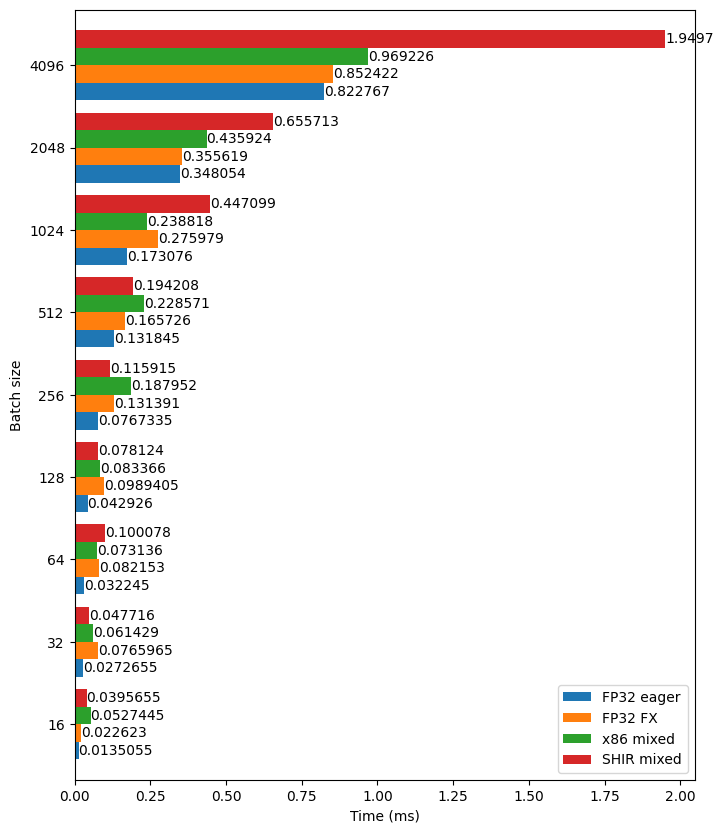

In [3]:
ax = (pd.DataFrame({
    'FP32 eager': pd.read_csv('local_metrics/simple_slp/fp32_eager.csv').set_axis(BATCH_SIZES, axis='columns').median(),
    'FP32 FX': pd.read_csv('local_metrics/simple_slp/fp32_fx.csv').set_axis(BATCH_SIZES, axis='columns').median(),
    'x86 mixed': pd.read_csv('local_metrics/simple_slp/x86_mixed_inductor.csv').set_axis(BATCH_SIZES, axis='columns').median(),
    'SHIR mixed': pd.read_csv('local_metrics/simple_slp/shir_mixed_inductor.csv').set_axis(BATCH_SIZES, axis='columns').median(),
}) / 1_000_000).plot.barh(width=0.85, figsize=(8, 10))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
  ax.bar_label(container)

### x86 Quantization

In [4]:
df_old_way = pd.read_csv('local_metrics/simple_slp/x86_maybe_inductor.csv')
display(df_old_way)

,x86 inductor b16,x86 inductor b32,x86 inductor b64,x86 inductor b128,x86 inductor b256,x86 inductor b512,x86 inductor b1024,x86 inductor b2048,x86 inductor b4096
0,5808164502,1375210113,1427062615,1414052394,1412007941,1416595315,1409487825,1404405124,1421140097
1,378151,409644,588929,1232493,951776,1277573,904660,1309325,3492874
2,381331,414608,1737577,1488613,906430,591723,838296,996810,7117837
3,328606,350073,2396398,2112877,409076,505677,1662450,989639,2499564
4,324048,347539,1430079,1436643,398011,1106811,1780731,1040574,2336363
...,...,...,...,...,...,...,...,...,...
995,297101,336676,1202481,1221594,393172,1343205,620107,953461,3559055
996,296195,320891,1198925,1230211,393282,1335467,600649,1018568,4491976
997,296494,320416,1197805,1218151,391714,1347238,593621,969842,5174790
998,300291,319076,1192239,1235285,403514,1363449,605986,1106410,5084143


In [5]:
df_new_way = pd.read_csv('local_metrics/simple_slp/x86_mixed_inductor.csv')
display(df_new_way)

,x86 inductor b16,x86 inductor b32,x86 inductor b64,x86 inductor b128,x86 inductor b256,x86 inductor b512,x86 inductor b1024,x86 inductor b2048,x86 inductor b4096
0,5440184563,1515667501,1469599004,1493247961,1512443715,1534704776,1464426934,1460452022,1480212762
1,121132,122115,129895,132447,397650,504290,317779,441192,905176
2,76703,91645,96137,103290,229549,669855,302890,407556,869323
3,65851,107057,86228,94191,225641,1630415,575150,692303,933023
4,61249,75405,104978,89938,218891,308367,2521003,442809,826738
...,...,...,...,...,...,...,...,...,...
995,52311,60374,72500,90166,185120,153977,245957,372148,1019509
996,50767,60575,72988,82980,187503,149520,234867,385357,915253
997,51757,59077,71135,80659,186555,142273,235890,376715,976519
998,52792,64377,71808,80385,187331,169907,246974,475870,1010089


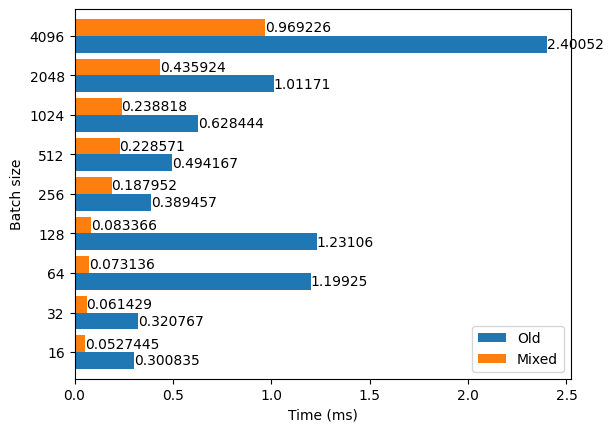

In [6]:
ax = (pd.DataFrame({
    'Old': df_old_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Mixed': df_new_way.set_axis(BATCH_SIZES, axis='columns').median(),
}) / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
  ax.bar_label(container)

### SHIR Quantization

In [7]:
df_old_way = pd.read_csv('local_metrics/simple_slp/shir_maybe_inductor.csv')
display(df_old_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,5036221795,1427545713,1401876022,1391902458,1388624547,1396732769,1408789800,1398099006,1398293991
1,98932,120509,151217,144890,195194,799873,549706,951028,1828519
2,63241,90094,106349,180360,159102,241870,576861,619909,1468963
3,61445,82460,93941,189952,145231,225268,392573,719979,1535454
4,52469,79950,90765,194086,140520,304547,372752,705572,1374340
...,...,...,...,...,...,...,...,...,...
995,49350,138344,76826,94405,200083,266508,327126,597859,1478432
996,51618,137760,77203,92890,196831,276198,329160,596928,1894927
997,56487,137483,75787,91490,202322,266604,340525,631862,1443894
998,47397,143641,75730,96481,199250,301205,322184,603597,1956001


In [8]:
df_new_way = pd.read_csv('local_metrics/simple_slp/shir_mixed_inductor.csv')
display(df_new_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,5268257552,1480204631,1521518162,1477577422,1455418440,1454370109,1434056989,1565904339,1459630774
1,84352,94843,114719,126108,186623,290673,975310,1143092,1827924
2,53154,60598,81041,91774,215255,313805,588796,1003077,2102884
3,48593,59216,71206,83032,231081,186497,335787,638003,1624598
4,44761,83516,71389,84485,231494,184815,324099,616967,2058036
...,...,...,...,...,...,...,...,...,...
995,41580,51042,100380,76769,118818,206540,386045,767311,2016529
996,40150,48037,101655,89255,113538,189604,437352,943693,1486483
997,39396,48407,99931,78302,115918,196188,463605,690768,1919683
998,39038,48896,98572,80068,111424,201983,438536,754619,1987735


In [9]:
df_cpp_way = pd.read_csv('local_metrics/simple_slp/shir_cpp_inductor.csv')
display(df_cpp_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,21725744913,5229150703,5243658591,5182209409,5231628766,5190350112,5179082595,5199505741,5184093691
1,87553,115252,106066,115445,833551,480544,598125,1153093,1863398
2,47472,67358,81156,102372,154623,427676,537061,963981,2059863
3,42333,52950,68507,214894,134400,189981,322145,605158,3273952
4,41496,57518,105146,189997,134459,187731,309794,592703,2763712
...,...,...,...,...,...,...,...,...,...
995,37599,43901,83879,69361,102202,173829,315616,694878,2001529
996,34312,41340,83411,69297,100181,173271,285888,602262,1430406
997,33278,41830,83894,72017,101881,178679,302195,885649,2037456
998,34928,40111,86029,73493,105271,179952,310055,655726,1881068


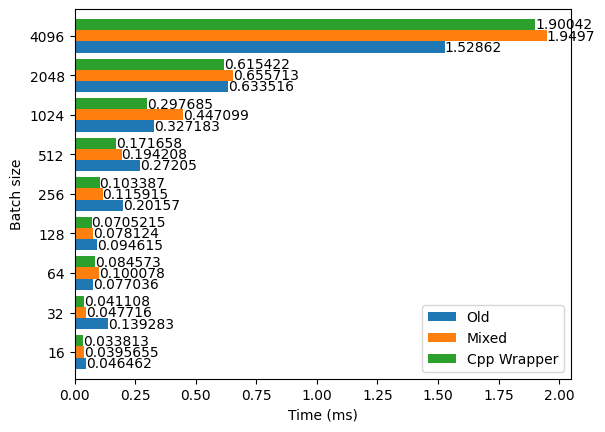

In [10]:
ax = (pd.DataFrame({
    'Old': df_old_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Mixed': df_new_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Cpp Wrapper': df_cpp_way.set_axis(BATCH_SIZES, axis='columns').median(),
}) / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
  ax.bar_label(container)

## SLP Model --- On the server

### x86 Quantization

In [11]:
df_old_way = pd.read_csv('server_metrics/simple_slp/x86_maybe_inductor.csv')
display(df_old_way)

,x86 inductor b16,x86 inductor b32,x86 inductor b64,x86 inductor b128,x86 inductor b256,x86 inductor b512,x86 inductor b1024,x86 inductor b2048,x86 inductor b4096
0,8095357249,2047192716,2053251269,2038833995,2045001073,2044921138,2019665739,2039943216,2047367310
1,2949322,2868447,3672856,2255531,2213204,2417817,2113967,2227990,3237739
2,2898023,2740972,3330381,2187939,1922644,2001312,1963282,1576063,1985664
3,2845032,2717130,3144907,2135274,1806987,1931514,1853212,1525340,1830171
4,2713911,2580836,3133775,2053926,1787169,1898539,1761146,1441315,1642686
...,...,...,...,...,...,...,...,...,...
995,1141222,1148364,999803,1086886,933100,963836,1073630,1238326,1605980
996,1133471,1146451,1002255,1087302,945522,960777,1105204,1471937,1616520
997,1132637,1145578,993479,1091372,926974,973724,1065767,1353633,1711287
998,1142718,1149847,1006996,1090537,953723,976848,1092575,1264138,2890285


In [12]:
df_new_way = pd.read_csv('server_metrics/simple_slp/x86_mixed_inductor.csv')
display(df_new_way)

,x86 inductor b16,x86 inductor b32,x86 inductor b64,x86 inductor b128,x86 inductor b256,x86 inductor b512,x86 inductor b1024,x86 inductor b2048,x86 inductor b4096
0,8148491619,2121844188,2099080480,2112760774,2144236202,2114952790,2105978205,2124358994,2200993971
1,438549,528993,529113,552145,459703,504843,660546,731717,1084141
2,388586,426421,424778,491065,428131,444539,639077,628793,1413747
3,396130,428604,418429,506201,422788,428045,572706,596096,833359
4,353415,411082,413296,469181,369919,468754,559993,543133,917377
...,...,...,...,...,...,...,...,...,...
995,139372,190702,211618,278244,233095,236728,377730,495544,612995
996,137453,188786,223596,277567,245485,244467,334059,522525,884390
997,145937,190061,212504,278327,237180,241764,318276,537052,738160
998,140095,190448,253358,288846,225603,250964,354786,501129,663124


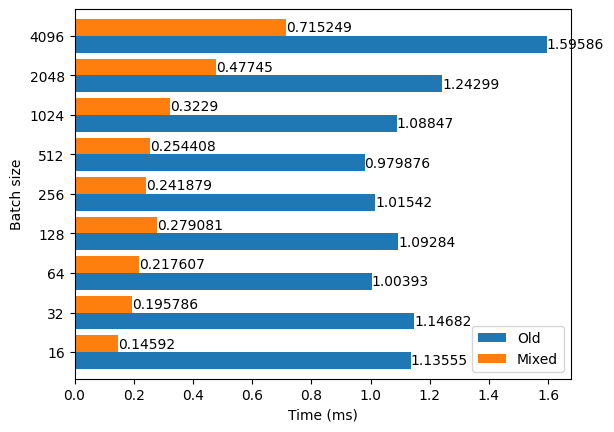

In [13]:
ax = (pd.DataFrame({
    'Old': df_old_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Mixed': df_new_way.set_axis(BATCH_SIZES, axis='columns').median(),
}) / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
  ax.bar_label(container)

### SHIR Quantization

In [14]:
df_old_way = pd.read_csv('server_metrics/simple_slp/shir_maybe_inductor.csv')
display(df_old_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,8091202783,2066220051,2066553192,2244805677,2079824459,2054760913,2051045593,2004074650,2066353602
1,767884,1085720,1781527,2762104,769709,830830,1104852,2081559,4639521
2,715750,945116,1729741,2697334,629438,728759,1038591,1989879,3481676
3,665860,960028,1577520,2548852,626875,671786,950411,1851090,3220949
4,655438,953471,1532958,2554243,603020,669467,914802,1820601,3037704
...,...,...,...,...,...,...,...,...,...
995,252335,404025,708131,1323598,339178,455574,812367,1546921,3489776
996,247340,397370,694283,1324836,333368,443473,770014,1517787,3269129
997,245523,395397,707572,1317469,326805,434643,795120,1609847,3082749
998,249624,390172,720728,1313431,321554,431816,738533,1516376,3036125


In [15]:
df_new_way = pd.read_csv('server_metrics/simple_slp/shir_mixed_inductor.csv')
display(df_new_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,8173632026,2190935710,2175359210,2171144683,2148120993,2143418903,2137829797,2140832796,2136028634
1,679602,1003460,1587088,2801820,499057,828622,1879520,2239988,5063730
2,577571,942281,1450976,2778811,467681,728469,1348397,2864405,4700508
3,562893,882549,1448078,2594383,453837,624222,1202777,2031522,3751439
4,569584,878904,1447006,2586374,468081,589200,1158576,1899011,4031147
...,...,...,...,...,...,...,...,...,...
995,206484,336719,697675,1358167,274194,388254,626876,1566284,3724711
996,212682,334367,698409,1340274,283386,365471,727229,1984355,3015282
997,205000,334189,686159,1329733,290265,378405,622179,1768509,4198007
998,206106,339146,676151,1343144,262558,390785,597927,1653542,3848528


In [16]:
df_cpp_way = pd.read_csv('server_metrics/simple_slp/shir_cpp_inductor.csv')
display(df_cpp_way)

,SHIR inductor b16,SHIR inductor b32,SHIR inductor b64,SHIR inductor b128,SHIR inductor b256,SHIR inductor b512,SHIR inductor b1024,SHIR inductor b2048,SHIR inductor b4096
0,12792337112,6541582484,6673324828,6609694606,6536607702,6507102869,6492263161,6508706350,6681369804
1,555390,911422,1899533,2814698,572194,814870,1842156,2187943,4179330
2,462007,803104,1606132,2711565,517078,726595,1238171,2813906,4050805
3,449697,781978,1602274,2410364,474143,655079,1092195,1765891,3185990
4,445170,787727,1539271,2401614,494227,600565,1057339,1689667,3602103
...,...,...,...,...,...,...,...,...,...
995,179404,299771,691629,1241719,246892,359217,709942,1593627,3904417
996,177740,295946,662560,1238913,248045,355976,683242,1480715,2983401
997,183612,297121,660505,1231121,248261,364498,691003,1544152,3440898
998,179670,295687,679602,1222247,270514,348925,657347,1495818,3294576


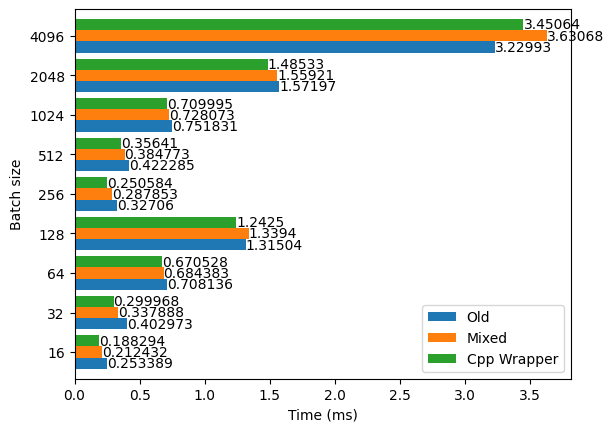

In [17]:
ax = (pd.DataFrame({
    'Old': df_old_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Mixed': df_new_way.set_axis(BATCH_SIZES, axis='columns').median(),
    'Cpp Wrapper': df_cpp_way.set_axis(BATCH_SIZES, axis='columns').median(),
}) / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
  ax.bar_label(container)